In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scienceplots
import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [21]:
x = np.hstack((aa, hh, bb, total_coords))

In [22]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [23]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [24]:
cd_orig = target_df.iloc[:,3].values # Cd values
cl_orig = target_df.iloc[:,4].values# Cl values

In [25]:
cd_nor = (cd_orig-np.min(cd_orig))/(np.max(cd_orig)-np.min(cd_orig))
cl_nor = (cl_orig-np.min(cl_orig))/(np.max(cl_orig)-np.min(cl_orig))

In [26]:
y = np.hstack((cd_nor.reshape((-1,1)), cl_nor.reshape((-1,1))))

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [28]:
x_train.shape

(100, 113)

In [29]:
y_train.shape

(100, 2)

In [30]:
# Getting indexes of training and test dataset
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))

In [31]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 2)                 258   

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
model_directory = "D:\\TrainedModels\\20221129"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [35]:
ckpt_name = model_directory + "20221129steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_ClCdNormalized_checkpoint.h5"
ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="loss", verbose=0,
                                          save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=300, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [36]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [37]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
5/5 [==============================] - 1s 4ms/step - loss: 0.2565 - rmse: 0.5065 - lr: 0.0010
Epoch 2/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.1013 - rmse: 0.3182 - lr: 0.0010
Epoch 3/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0682 - rmse: 0.2612 - lr: 0.0010
Epoch 4/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0445 - rmse: 0.2109 - lr: 0.0010
Epoch 5/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0358 - rmse: 0.1891 - lr: 0.0010
Epoch 6/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0240 - rmse: 0.1549 - lr: 0.0010
Epoch 7/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0172 - rmse: 0.1310 - lr: 0.0010
Epoch 8/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0139 - rmse: 0.1181 - lr: 0.0010
Epoch 9/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0134 - rmse: 0.1157 - lr: 0.0010
Epoch 10/10000
5/5 [========

Epoch 76/10000
5/5 [==============================] - 0s 3ms/step - loss: 3.9424e-04 - rmse: 0.0199 - lr: 0.0010
Epoch 77/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.3552e-04 - rmse: 0.0153 - lr: 0.0010
Epoch 78/10000
5/5 [==============================] - 0s 4ms/step - loss: 1.9881e-04 - rmse: 0.0141 - lr: 0.0010
Epoch 79/10000
5/5 [==============================] - 0s 3ms/step - loss: 3.8295e-04 - rmse: 0.0196 - lr: 0.0010
Epoch 80/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.6151e-04 - rmse: 0.0162 - lr: 0.0010
Epoch 81/10000
5/5 [==============================] - 0s 3ms/step - loss: 2.5426e-04 - rmse: 0.0159 - lr: 0.0010
Epoch 82/10000
5/5 [==============================] - 0s 3ms/step - loss: 3.4762e-04 - rmse: 0.0186 - lr: 0.0010
Epoch 83/10000
5/5 [==============================] - 0s 3ms/step - loss: 4.4336e-04 - rmse: 0.0211 - lr: 0.0010
Epoch 84/10000
5/5 [==============================] - 0s 3ms/step - loss: 7.1142e-04 - rmse: 0.0

5/5 [==============================] - 0s 4ms/step - loss: 3.0790e-05 - rmse: 0.0055 - lr: 0.0010
Epoch 149/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.6029e-05 - rmse: 0.0060 - lr: 0.0010
Epoch 150/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.1588e-05 - rmse: 0.0056 - lr: 0.0010
Epoch 151/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.5872e-05 - rmse: 0.0068 - lr: 0.0010
Epoch 152/10000
5/5 [==============================] - 0s 3ms/step - loss: 4.0529e-05 - rmse: 0.0064 - lr: 0.0010
Epoch 153/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.0585e-05 - rmse: 0.0055 - lr: 0.0010
Epoch 154/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.8713e-05 - rmse: 0.0054 - lr: 0.0010
Epoch 155/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.8749e-05 - rmse: 0.0062 - lr: 0.0010
Epoch 156/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.6003e-05 - rmse: 0.0060 - l

5/5 [==============================] - 0s 4ms/step - loss: 3.6281e-05 - rmse: 0.0060 - lr: 0.0010
Epoch 221/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.8488e-05 - rmse: 0.0053 - lr: 0.0010
Epoch 222/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.8830e-05 - rmse: 0.0054 - lr: 0.0010
Epoch 223/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.7163e-05 - rmse: 0.0076 - lr: 0.0010
Epoch 224/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8144e-05 - rmse: 0.0076 - lr: 0.0010
Epoch 225/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.1134e-05 - rmse: 0.0056 - lr: 0.0010
Epoch 226/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.2968e-05 - rmse: 0.0066 - lr: 0.0010
Epoch 227/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.5436e-05 - rmse: 0.0067 - lr: 0.0010
Epoch 228/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.5288e-05 - rmse: 0.0059 - l

5/5 [==============================] - 0s 4ms/step - loss: 5.6101e-05 - rmse: 0.0075 - lr: 0.0010
Epoch 293/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.4788e-05 - rmse: 0.0074 - lr: 0.0010
Epoch 294/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.4505e-05 - rmse: 0.0059 - lr: 0.0010
Epoch 295/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.5451e-05 - rmse: 0.0060 - lr: 0.0010
Epoch 296/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.0068e-05 - rmse: 0.0055 - lr: 0.0010
Epoch 297/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.0664e-05 - rmse: 0.0055 - lr: 0.0010
Epoch 298/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.5989e-05 - rmse: 0.0068 - lr: 0.0010
Epoch 299/10000
5/5 [==============================] - 0s 4ms/step - loss: 5.8854e-05 - rmse: 0.0077 - lr: 0.0010
Epoch 300/10000
5/5 [==============================] - 0s 4ms/step - loss: 1.3301e-04 - rmse: 0.0115 - l

5/5 [==============================] - 0s 4ms/step - loss: 5.5573e-04 - rmse: 0.0236 - lr: 0.0010
Epoch 365/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0377 - lr: 0.0010
Epoch 366/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.2323e-04 - rmse: 0.0304 - lr: 0.0010
Epoch 367/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0330 - lr: 0.0010
Epoch 368/10000
5/5 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0385 - lr: 0.0010
Epoch 369/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0429 - lr: 0.0010
Epoch 370/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.1489e-04 - rmse: 0.0302 - lr: 0.0010
Epoch 371/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.8915e-04 - rmse: 0.0281 - lr: 0.0010
Epoch 372/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.1168e-04 - rmse: 0.0247 - lr: 0.0010
Epoch 

5/5 [==============================] - 0s 5ms/step - loss: 3.9900e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 437/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.3944e-06 - rmse: 0.0021 - lr: 0.0010
Epoch 438/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.6582e-06 - rmse: 0.0022 - lr: 0.0010
Epoch 439/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.2000e-06 - rmse: 0.0023 - lr: 0.0010
Epoch 440/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.8967e-06 - rmse: 0.0022 - lr: 0.0010
Epoch 441/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.3356e-06 - rmse: 0.0021 - lr: 0.0010
Epoch 442/10000
5/5 [==============================] - 0s 4ms/step - loss: 3.7179e-06 - rmse: 0.0019 - lr: 0.0010
Epoch 443/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.3367e-06 - rmse: 0.0018 - lr: 0.0010
Epoch 444/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.4539e-06 - rmse: 0.0019 - l

5/5 [==============================] - 0s 5ms/step - loss: 9.7281e-06 - rmse: 0.0031 - lr: 0.0010
Epoch 509/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4124e-05 - rmse: 0.0038 - lr: 0.0010
Epoch 510/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5329e-05 - rmse: 0.0039 - lr: 0.0010
Epoch 511/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.0604e-05 - rmse: 0.0045 - lr: 0.0010
Epoch 512/10000
5/5 [==============================] - 0s 4ms/step - loss: 1.0238e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 513/10000
5/5 [==============================] - 0s 4ms/step - loss: 1.3737e-05 - rmse: 0.0037 - lr: 0.0010
Epoch 514/10000
5/5 [==============================] - 0s 4ms/step - loss: 7.4622e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 515/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1681e-05 - rmse: 0.0034 - lr: 0.0010
Epoch 516/10000
5/5 [==============================] - 0s 4ms/step - loss: 1.3084e-05 - rmse: 0.0036 - l

5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0506 - lr: 0.0010
Epoch 581/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0447 - lr: 0.0010
Epoch 582/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0422 - lr: 0.0010
Epoch 583/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0413 - lr: 0.0010
Epoch 584/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0426 - lr: 0.0010
Epoch 585/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0503 - lr: 0.0010
Epoch 586/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0510 - lr: 0.0010
Epoch 587/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0525 - lr: 0.0010
Epoch 588/10000
5/5 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0482 - lr: 0.0010
Epoch 589/10000
5/5 [=====

5/5 [==============================] - 0s 4ms/step - loss: 7.1050e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 653/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.1532e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 654/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.5337e-06 - rmse: 0.0029 - lr: 0.0010
Epoch 655/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0101e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 656/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.7890e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 657/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8115e-06 - rmse: 0.0026 - lr: 0.0010
Epoch 658/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9054e-06 - rmse: 0.0024 - lr: 0.0010
Epoch 659/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.9437e-06 - rmse: 0.0024 - lr: 0.0010
Epoch 660/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.5428e-06 - rmse: 0.0026 - l

5/5 [==============================] - 0s 5ms/step - loss: 2.5925e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 725/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7236e-06 - rmse: 0.0017 - lr: 0.0010
Epoch 726/10000
5/5 [==============================] - 0s 4ms/step - loss: 2.4083e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 727/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.4168e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 728/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5114e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 729/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.6688e-06 - rmse: 0.0019 - lr: 0.0010
Epoch 730/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7723e-06 - rmse: 0.0017 - lr: 0.0010
Epoch 731/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.1011e-06 - rmse: 0.0018 - lr: 0.0010
Epoch 732/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.6379e-06 - rmse: 0.0016 - l

5/5 [==============================] - 0s 5ms/step - loss: 3.6603e-05 - rmse: 0.0061 - lr: 0.0010
Epoch 797/10000
5/5 [==============================] - 0s 4ms/step - loss: 4.2038e-05 - rmse: 0.0065 - lr: 0.0010
Epoch 798/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9078e-05 - rmse: 0.0063 - lr: 0.0010
Epoch 799/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9048e-05 - rmse: 0.0062 - lr: 0.0010
Epoch 800/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.0472e-05 - rmse: 0.0078 - lr: 0.0010
Epoch 801/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.5363e-05 - rmse: 0.0067 - lr: 0.0010
Epoch 802/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.7038e-05 - rmse: 0.0093 - lr: 0.0010
Epoch 803/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6082e-05 - rmse: 0.0093 - lr: 0.0010
Epoch 804/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.6429e-05 - rmse: 0.0087 - l

5/5 [==============================] - 0s 5ms/step - loss: 7.6662e-06 - rmse: 0.0028 - lr: 0.0010
Epoch 869/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1554e-05 - rmse: 0.0034 - lr: 0.0010
Epoch 870/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.7215e-06 - rmse: 0.0031 - lr: 0.0010
Epoch 871/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1971e-05 - rmse: 0.0035 - lr: 0.0010
Epoch 872/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0265e-05 - rmse: 0.0032 - lr: 0.0010
Epoch 873/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8281e-06 - rmse: 0.0026 - lr: 0.0010
Epoch 874/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.9070e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 875/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2094e-05 - rmse: 0.0035 - lr: 0.0010
Epoch 876/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2506e-05 - rmse: 0.0035 - l

5/5 [==============================] - 0s 5ms/step - loss: 1.4973e-06 - rmse: 0.0012 - lr: 0.0010
Epoch 941/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0359e-06 - rmse: 0.0014 - lr: 0.0010
Epoch 942/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2044e-06 - rmse: 0.0015 - lr: 0.0010
Epoch 943/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9754e-06 - rmse: 0.0017 - lr: 0.0010
Epoch 944/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.6343e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 945/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1587e-06 - rmse: 0.0015 - lr: 0.0010
Epoch 946/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0851e-06 - rmse: 0.0014 - lr: 0.0010
Epoch 947/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6037e-06 - rmse: 0.0013 - lr: 0.0010
Epoch 948/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6893e-06 - rmse: 0.0013 - l

Epoch 1012/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.4803e-06 - rmse: 0.0025 - lr: 0.0010
Epoch 1013/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.1981e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 1014/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.0616e-06 - rmse: 0.0028 - lr: 0.0010
Epoch 1015/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0759e-05 - rmse: 0.0033 - lr: 0.0010
Epoch 1016/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.0249e-06 - rmse: 0.0028 - lr: 0.0010
Epoch 1017/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.7442e-06 - rmse: 0.0024 - lr: 0.0010
Epoch 1018/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.3694e-06 - rmse: 0.0027 - lr: 0.0010
Epoch 1019/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.9787e-06 - rmse: 0.0030 - lr: 0.0010
Epoch 1020/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.05

Epoch 1084/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2417e-05 - rmse: 0.0047 - lr: 0.0010
Epoch 1085/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1612e-05 - rmse: 0.0046 - lr: 0.0010
Epoch 1086/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2416e-05 - rmse: 0.0047 - lr: 0.0010
Epoch 1087/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9556e-05 - rmse: 0.0044 - lr: 0.0010
Epoch 1088/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8323e-05 - rmse: 0.0043 - lr: 0.0010
Epoch 1089/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0838e-05 - rmse: 0.0046 - lr: 0.0010
Epoch 1090/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.6288e-05 - rmse: 0.0051 - lr: 0.0010
Epoch 1091/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7960e-05 - rmse: 0.0042 - lr: 0.0010
Epoch 1092/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.58

5/5 [==============================] - 0s 5ms/step - loss: 5.4675e-06 - rmse: 0.0023 - lr: 0.0010
Epoch 1156/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.6266e-06 - rmse: 0.0022 - lr: 0.0010
Epoch 1157/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.1571e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 1158/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.0894e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 1159/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.2782e-06 - rmse: 0.0021 - lr: 0.0010
Epoch 1160/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.5429e-06 - rmse: 0.0021 - lr: 0.0010
Epoch 1161/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.0306e-06 - rmse: 0.0020 - lr: 0.0010
Epoch 1162/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.4413e-06 - rmse: 0.0021 - lr: 0.0010
Epoch 1163/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.1566e-06 - rmse: 0.

5/5 [==============================] - 0s 5ms/step - loss: 3.6523e-06 - rmse: 0.0019 - lr: 0.0010
Epoch 1227/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2920e-06 - rmse: 0.0018 - lr: 0.0010
Epoch 1228/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.5891e-06 - rmse: 0.0019 - lr: 0.0010
Epoch 1229/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.6346e-06 - rmse: 0.0019 - lr: 0.0010
Epoch 1230/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.0787e-06 - rmse: 0.0018 - lr: 0.0010
Epoch 1231/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2497e-06 - rmse: 0.0018 - lr: 0.0010
Epoch 1232/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7152e-06 - rmse: 0.0016 - lr: 0.0010
Epoch 1233/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3721e-06 - rmse: 0.0015 - lr: 0.0010
Epoch 1234/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2223e-06 - rmse: 0.

5/5 [==============================] - 0s 5ms/step - loss: 1.5221e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1295/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5832e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 1296/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4835e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1297/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6885e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 1298/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3538e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1299/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3031e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1300/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2009e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1301/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1628e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1302/10000
5/5 [==============================] - 0s 5ms/st

5/5 [==============================] - 0s 4ms/step - loss: 1.0371e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 1363/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0736e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 1364/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3287e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1365/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2689e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1366/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.7728e-07 - rmse: 9.3663e-04 - lr: 5.0000e-04
Epoch 1367/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.5958e-07 - rmse: 9.2713e-04 - lr: 5.0000e-04
Epoch 1368/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.7523e-07 - rmse: 9.8754e-04 - lr: 5.0000e-04
Epoch 1369/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.8730e-07 - rmse: 9.4197e-04 - lr: 5.0000e-04
Epoch 1370/10000
5/5 [===========================

5/5 [==============================] - 0s 5ms/step - loss: 6.7870e-07 - rmse: 8.2383e-04 - lr: 5.0000e-04
Epoch 1430/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.9664e-07 - rmse: 8.3465e-04 - lr: 5.0000e-04
Epoch 1431/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.1589e-07 - rmse: 8.4610e-04 - lr: 5.0000e-04
Epoch 1432/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.6793e-07 - rmse: 8.7632e-04 - lr: 5.0000e-04
Epoch 1433/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.7181e-07 - rmse: 8.7853e-04 - lr: 5.0000e-04
Epoch 1434/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.5472e-07 - rmse: 8.0915e-04 - lr: 5.0000e-04
Epoch 1435/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.4644e-07 - rmse: 8.0402e-04 - lr: 5.0000e-04
Epoch 1436/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.7846e-07 - rmse: 8.2369e-04 - lr: 5.0000e-04
Epoch 1437/10000
5/5 [===========

5/5 [==============================] - 0s 5ms/step - loss: 1.3881e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1497/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0628e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 1498/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.8506e-07 - rmse: 8.8604e-04 - lr: 5.0000e-04
Epoch 1499/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.5242e-07 - rmse: 9.7592e-04 - lr: 5.0000e-04
Epoch 1500/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.7995e-07 - rmse: 9.3806e-04 - lr: 5.0000e-04
Epoch 1501/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.2878e-07 - rmse: 7.9295e-04 - lr: 5.0000e-04
Epoch 1502/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.2613e-07 - rmse: 8.5213e-04 - lr: 5.0000e-04
Epoch 1503/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.9385e-07 - rmse: 8.9098e-04 - lr: 5.0000e-04
Epoch 1504/10000
5/5 [===================

5/5 [==============================] - 0s 4ms/step - loss: 1.8400e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1564/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9214e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 1565/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5228e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1566/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3239e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1567/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4865e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 1568/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1362e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 1569/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.0953e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 1570/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.0111e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 1571/10000
5/5 [==============================] - 0s 5ms/st

Epoch 1632/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6474e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 1633/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.1034e-06 - rmse: 0.0030 - lr: 5.0000e-04
Epoch 1634/10000
5/5 [==============================] - 0s 4ms/step - loss: 6.2990e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 1635/10000
5/5 [==============================] - 0s 4ms/step - loss: 8.1234e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 1636/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.2242e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 1637/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8732e-06 - rmse: 0.0026 - lr: 5.0000e-04
Epoch 1638/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.5070e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 1639/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.2363e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 1640/10000
5/5 [==========================

5/5 [==============================] - 0s 5ms/step - loss: 6.0812e-06 - rmse: 0.0025 - lr: 5.0000e-04
Epoch 1701/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.4894e-06 - rmse: 0.0019 - lr: 5.0000e-04
Epoch 1702/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.2654e-06 - rmse: 0.0023 - lr: 5.0000e-04
Epoch 1703/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2864e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 1704/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3145e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 1705/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9341e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 1706/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1433e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 1707/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.0313e-06 - rmse: 0.0028 - lr: 5.0000e-04
Epoch 1708/10000
5/5 [==============================] - 0s 5ms/st

5/5 [==============================] - 0s 4ms/step - loss: 1.2975e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 1769/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0812e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 1770/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1079e-05 - rmse: 0.0033 - lr: 5.0000e-04
Epoch 1771/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3739e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 1772/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1621e-05 - rmse: 0.0034 - lr: 5.0000e-04
Epoch 1773/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7710e-05 - rmse: 0.0042 - lr: 5.0000e-04
Epoch 1774/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3505e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 1775/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2108e-05 - rmse: 0.0035 - lr: 5.0000e-04
Epoch 1776/10000
5/5 [==============================] - 0s 5ms/st

Epoch 1837/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0233e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 1838/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5647e-05 - rmse: 0.0040 - lr: 5.0000e-04
Epoch 1839/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9261e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 1840/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2646e-05 - rmse: 0.0036 - lr: 5.0000e-04
Epoch 1841/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6473e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 1842/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8446e-05 - rmse: 0.0043 - lr: 5.0000e-04
Epoch 1843/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0213e-05 - rmse: 0.0032 - lr: 5.0000e-04
Epoch 1844/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.7314e-06 - rmse: 0.0024 - lr: 5.0000e-04
Epoch 1845/10000
5/5 [==========================

Epoch 1906/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.0328e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 1907/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.3340e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 1908/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6794e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 1909/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2972e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 1910/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6156e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 1911/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.7026e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1912/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.9642e-06 - rmse: 0.0020 - lr: 5.0000e-04
Epoch 1913/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.5219e-06 - rmse: 0.0016 - lr: 5.0000e-04
Epoch 1914/10000
5/5 [==========================

5/5 [==============================] - 0s 5ms/step - loss: 5.4300e-07 - rmse: 7.3689e-04 - lr: 5.0000e-04
Epoch 1975/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.4111e-07 - rmse: 9.1712e-04 - lr: 5.0000e-04
Epoch 1976/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.9030e-07 - rmse: 9.9514e-04 - lr: 5.0000e-04
Epoch 1977/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.2150e-07 - rmse: 8.4941e-04 - lr: 5.0000e-04
Epoch 1978/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2378e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1979/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.5409e-07 - rmse: 9.7677e-04 - lr: 5.0000e-04
Epoch 1980/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1895e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 1981/10000
5/5 [==============================] - 0s 5ms/step - loss: 9.1443e-07 - rmse: 9.5626e-04 - lr: 5.0000e-04
Epoch 1982/10000
5/5 [===================

Epoch 2041/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.7434e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2042/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1178e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2043/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2415e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2044/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.2179e-07 - rmse: 9.0653e-04 - lr: 5.0000e-04
Epoch 2045/10000
5/5 [==============================] - 0s 4ms/step - loss: 9.5224e-07 - rmse: 9.7583e-04 - lr: 5.0000e-04
Epoch 2046/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.2639e-06 - rmse: 0.0011 - lr: 5.0000e-04
Epoch 2047/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.0249e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 2048/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5574e-07 - rmse: 7.4548e-04 - lr: 5.0000e-04
Epoch 2049/10000
5/5 [==============

5/5 [==============================] - 0s 5ms/step - loss: 9.6108e-07 - rmse: 9.8034e-04 - lr: 5.0000e-04
Epoch 2109/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.5145e-07 - rmse: 7.4260e-04 - lr: 5.0000e-04
Epoch 2110/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.2257e-07 - rmse: 7.8903e-04 - lr: 5.0000e-04
Epoch 2111/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.7421e-07 - rmse: 8.2110e-04 - lr: 5.0000e-04
Epoch 2112/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.6033e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2113/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2788e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 2114/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.1631e-06 - rmse: 0.0015 - lr: 5.0000e-04
Epoch 2115/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8133e-06 - rmse: 0.0013 - lr: 5.0000e-04
Epoch 2116/10000
5/5 [===========================

5/5 [==============================] - 0s 5ms/step - loss: 3.1793e-04 - rmse: 0.0178 - lr: 5.0000e-04
Epoch 2177/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.5758e-04 - rmse: 0.0126 - lr: 5.0000e-04
Epoch 2178/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1150e-04 - rmse: 0.0106 - lr: 5.0000e-04
Epoch 2179/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1388e-04 - rmse: 0.0107 - lr: 5.0000e-04
Epoch 2180/10000
5/5 [==============================] - 0s 5ms/step - loss: 7.5136e-05 - rmse: 0.0087 - lr: 5.0000e-04
Epoch 2181/10000
5/5 [==============================] - 0s 5ms/step - loss: 6.8818e-05 - rmse: 0.0083 - lr: 5.0000e-04
Epoch 2182/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.5630e-05 - rmse: 0.0060 - lr: 5.0000e-04
Epoch 2183/10000
5/5 [==============================] - 0s 5ms/step - loss: 5.0087e-05 - rmse: 0.0071 - lr: 5.0000e-04
Epoch 2184/10000
5/5 [==============================] - 0s 5ms/st

5/5 [==============================] - 0s 5ms/step - loss: 9.7749e-07 - rmse: 9.8868e-04 - lr: 5.0000e-04
Epoch 2245/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0606e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 2246/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0059e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 2247/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.1000e-06 - rmse: 0.0010 - lr: 5.0000e-04
Epoch 2248/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6958e-07 - rmse: 9.3251e-04 - lr: 5.0000e-04
Epoch 2249/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.4714e-06 - rmse: 0.0012 - lr: 5.0000e-04
Epoch 2250/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.9039e-06 - rmse: 0.0017 - lr: 5.0000e-04
Epoch 2251/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9404e-06 - rmse: 0.0014 - lr: 5.0000e-04
Epoch 2252/10000
5/5 [==============================] - 0

Epoch 2312/10000
5/5 [==============================] - 0s 5ms/step - loss: 4.4340e-07 - rmse: 6.6589e-04 - lr: 5.0000e-04
Epoch 2313/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.2265e-07 - rmse: 5.6802e-04 - lr: 5.0000e-04
Epoch 2314/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.2537e-07 - rmse: 4.7473e-04 - lr: 5.0000e-04
Epoch 2315/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8841e-07 - rmse: 5.3704e-04 - lr: 5.0000e-04
Epoch 2316/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.4620e-07 - rmse: 5.8839e-04 - lr: 5.0000e-04
Epoch 2317/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.5641e-07 - rmse: 5.9700e-04 - lr: 5.0000e-04
Epoch 2318/10000
5/5 [==============================] - 0s 5ms/step - loss: 3.6948e-07 - rmse: 6.0784e-04 - lr: 5.0000e-04
Epoch 2319/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.8713e-07 - rmse: 5.3584e-04 - lr: 5.0000e-04
Epoch 2320/10000

5/5 [==============================] - 0s 5ms/step - loss: 2.3419e-05 - rmse: 0.0048 - lr: 5.0000e-04
Epoch 2381/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.9622e-05 - rmse: 0.0044 - lr: 5.0000e-04
Epoch 2382/10000
5/5 [==============================] - 0s 5ms/step - loss: 2.0147e-05 - rmse: 0.0045 - lr: 5.0000e-04
Epoch 2383/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.8838e-05 - rmse: 0.0043 - lr: 5.0000e-04
Epoch 2384/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.3341e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 2385/10000
5/5 [==============================] - 0s 5ms/step - loss: 1.3690e-05 - rmse: 0.0037 - lr: 5.0000e-04
Epoch 2386/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.5517e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 2387/10000
5/5 [==============================] - 0s 5ms/step - loss: 8.6528e-06 - rmse: 0.0029 - lr: 5.0000e-04
Epoch 2388/10000
5/5 [==============================] - 0s 5ms/st

In [38]:
time = end - start
print("Training time:", time)

Training time: 0:00:58.814289


In [39]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\20221129\\MLP_revised\\test"+str(test_rate)+"_CdClNormalized"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

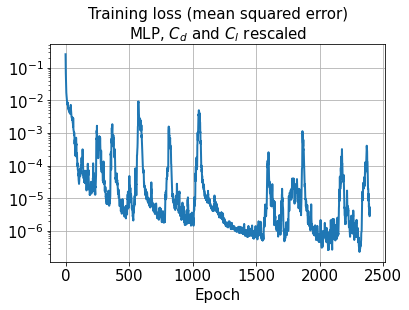

In [40]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, $C_d$ and $C_l$ rescaled', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

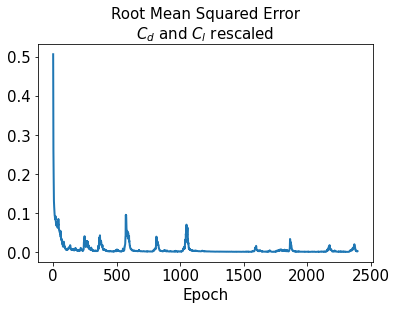

In [41]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\n$C_d$ and $C_l$ rescaled', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

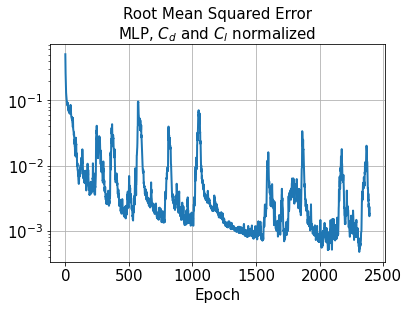

In [42]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, $C_d$ and $C_l$ normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [43]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 7.6699e-07 - rmse: 8.7578e-04


In [44]:
test_results = model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 9.8466e-05 - rmse: 0.0099


In [45]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

2/2 [==============================] - 0s 2ms/step


In [46]:
os.chdir(model_directory)
model_name = "20221129steadyValidation_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_ClCdNormalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [47]:
os.chdir(storage_dir)

In [48]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
mape_train = 100/(len(x_train))*np.abs(np.sum(decoded_train-y_train)/np.sum(y_train))
print(l2_error_train)
print(mape_train)

0.0015764652816789835
0.00035246491628301835


In [49]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
mape_test = 100/(len(x_test))*np.abs(np.sum(decoded_test-y_test)/np.sum(y_test))
print(l2_error_test)
print(mape_test)

0.020905029673677186
0.0036450662163141374


In [50]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
mape_Cd_train = 100/(len(x_train))*np.abs(np.sum(decoded_train[:,0]-y_train[:,0])/np.sum(y_train[:,0]))
print(l2_error_Cd_train)
print(mape_Cd_train)

0.0020348373229020873
1.4088226867666227e-05


In [51]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
mape_Cl_train = 100/(len(x_train))*np.abs(np.sum(decoded_train[:,1]-y_train[:,1])/np.sum(y_train[:,1]))
print(l2_error_Cl_train)
print(mape_Cl_train)

0.0013911427753247679
0.0005289449554542252


In [52]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
mape_Cd_test = 100/(len(x_test))*np.abs(np.sum(decoded_test[:,0]-y_test[:,0])/np.sum(y_test[:,0]))
print(l2_error_Cd_test)
print(mape_Cd_test)

0.034140803111434866
0.004694696104612824


In [53]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
mape_Cl_test = 100/(len(x_test))*np.abs(np.sum(decoded_test[:,1]-y_test[:,1])/np.sum(y_test[:,1]))
print(l2_error_Cl_test)
print(mape_Cl_test)

0.016795901062436433
0.0032419468361117704


In [54]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / (np.sum(y_train[i]**2)+1e-07))
    l2_error_train_list.append(l2_error_train_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / (np.sum(y_test[i]**2)+1e-07))
    l2_error_test_list.append(l2_error_test_data)

In [56]:
decoded_train.shape

(100, 2)

In [57]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i,0] - y_train[i,0])**2) / (np.sum(y_train[i,0]**2)+1e-07))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [58]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / (np.sum(y_train[i][1]**2)+1e-07))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [59]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / (np.sum(y_test[i][0]**2)+1e-07))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [60]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / (np.sum(y_test[i][1]**2)+1e-07))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

In [61]:
cd_train = y_train[:,0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
cl_train = y_train[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig)
decoded_cd_train = decoded_train[:,0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
decoded_cl_train = decoded_train[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig)

In [62]:
decoded_train = np.hstack((decoded_cd_train.reshape((-1,1)), decoded_cl_train.reshape((-1,1))))

In [63]:
cd_test = y_test[:,0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
cl_test = y_test[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig)
decoded_cd_test = decoded_test[:,0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
decoded_cl_test = decoded_test[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig)

In [64]:
decoded_test = np.hstack((decoded_cd_test.reshape((-1,1)), decoded_cl_test.reshape((-1,1))))

In [65]:
error_train_abs = np.abs(decoded_train - y_train)

In [66]:
error_test_abs = np.abs(decoded_test - y_test)

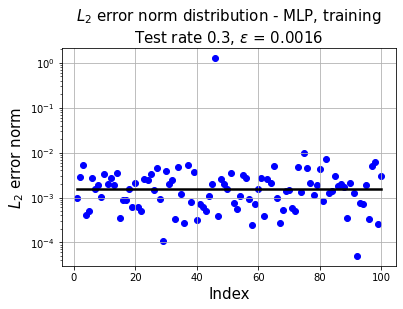

In [67]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

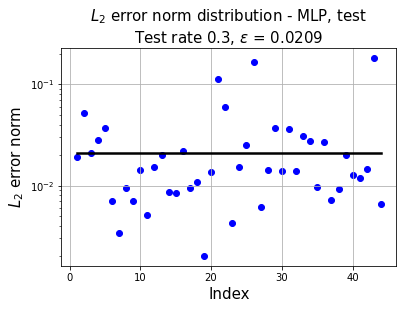

In [68]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

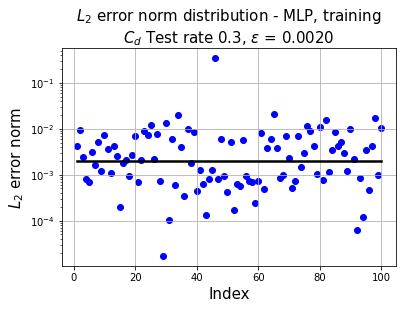

In [69]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

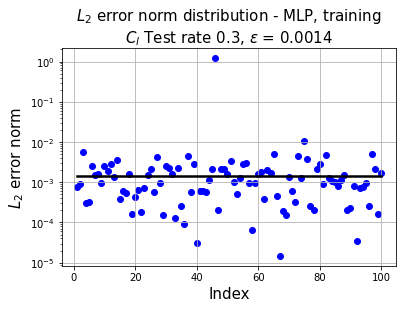

In [70]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

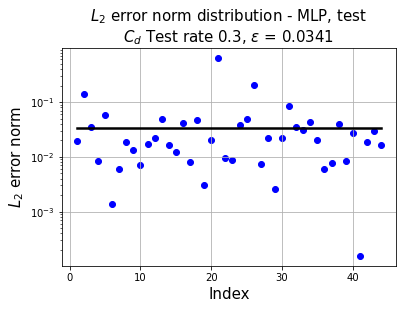

In [71]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_d$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

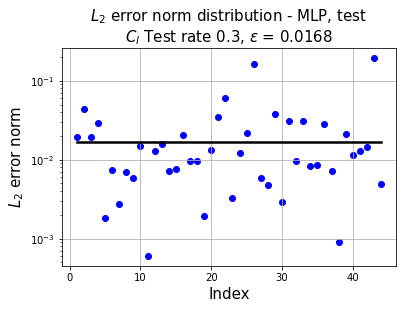

In [72]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\n$C_l$ Test rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [73]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [102]:
def CLCD_trainTestSplit_Plot(i, CD, cd, CL, cl, aTrain, aTest, iTrain, iTest):
    
    title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
        title_Cd, title_Cl = title_0_Cd, title_0_Cl
        savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
    else:
        title_Cd, title_Cl = title_n_Cd, title_n_Cl
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig), color='b', label='Training set')
    plt.scatter(aTest, iTest[:,0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

    # CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='b', label='Training set')
    plt.scatter(aTest, iTest[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

1/1 [==============================] - 0s 14ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0047, L2 error of Cl: 0.0048


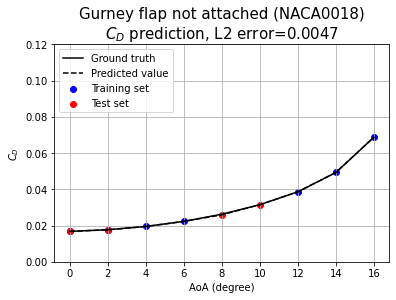

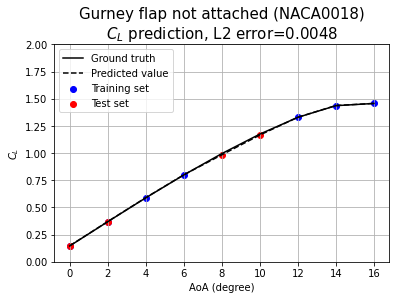

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0337, L2 error of Cl: 0.0072


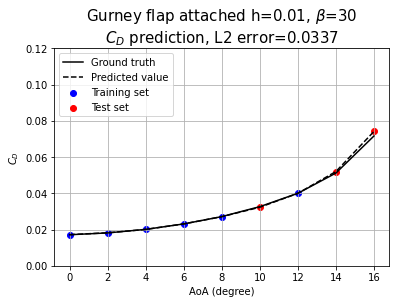

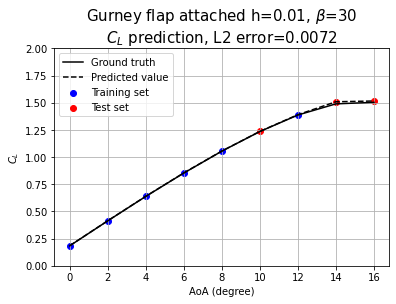

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0018, L2 error of Cl: 0.0082


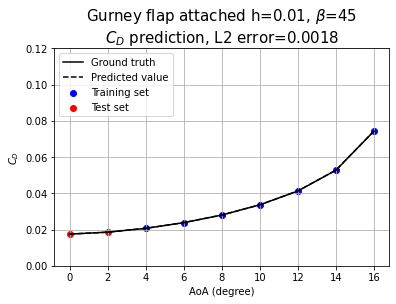

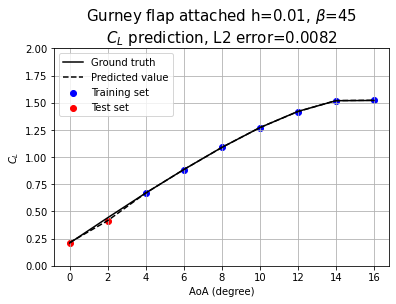

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0178, L2 error of Cl: 0.0075


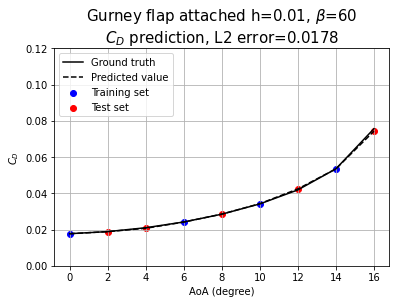

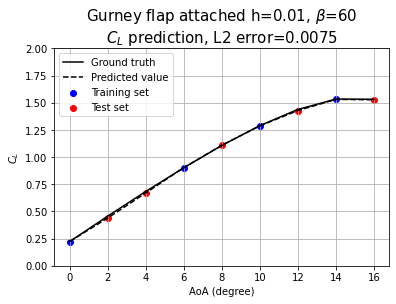

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0174, L2 error of Cl: 0.0172


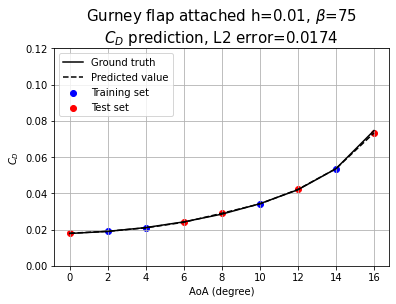

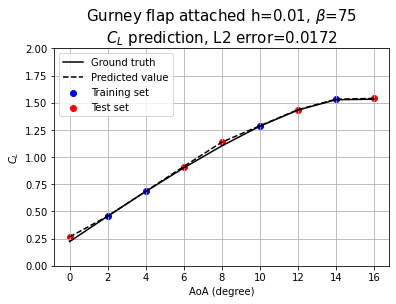

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0471, L2 error of Cl: 0.0086


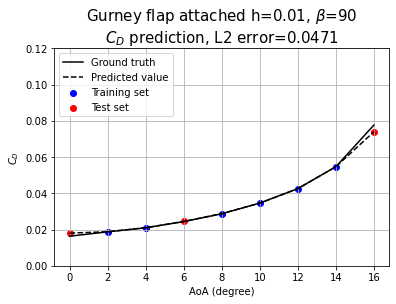

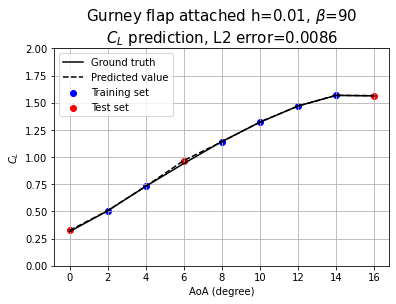

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0028, L2 error of Cl: 0.0035


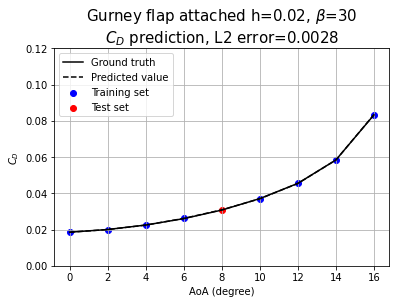

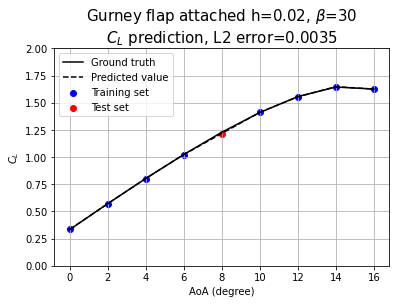

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0060, L2 error of Cl: 0.0052


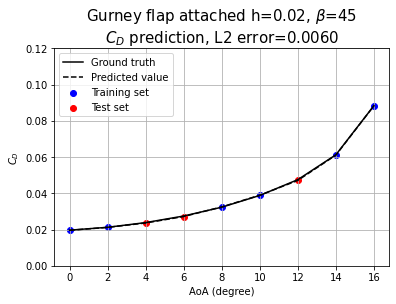

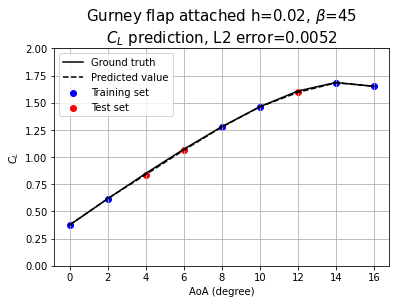

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0062, L2 error of Cl: 0.0062


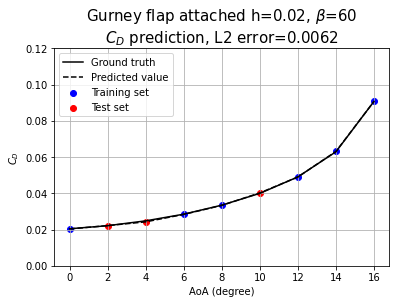

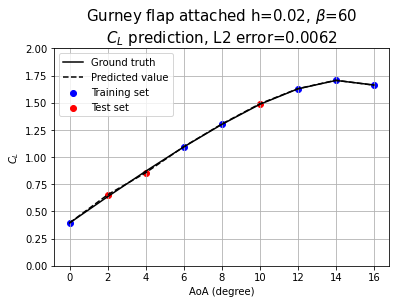

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0071, L2 error of Cl: 0.0064


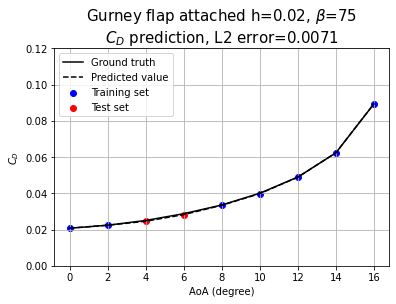

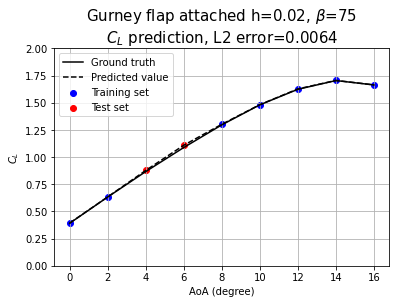

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0147, L2 error of Cl: 0.0201


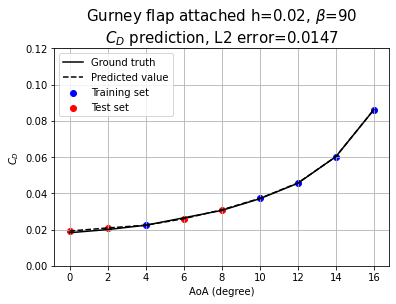

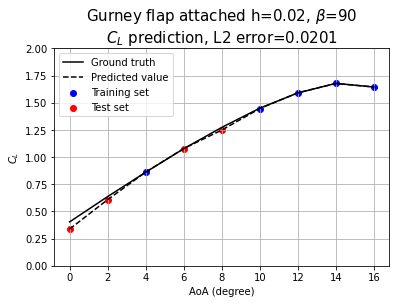

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0071, L2 error of Cl: 0.0062


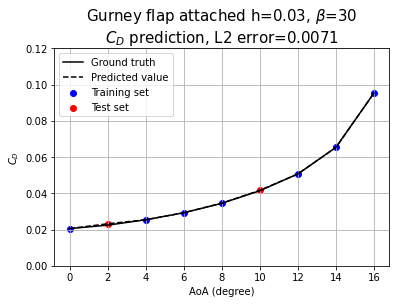

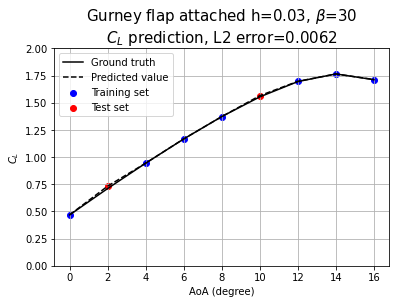

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0062, L2 error of Cl: 0.0041


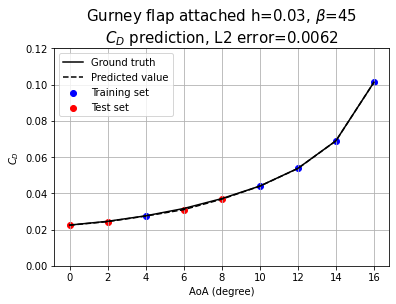

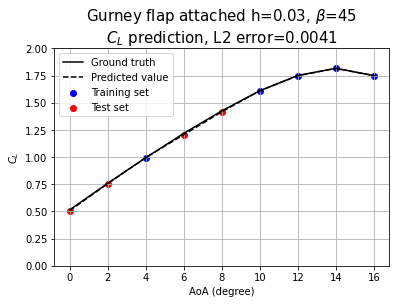

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0067, L2 error of Cl: 0.0058


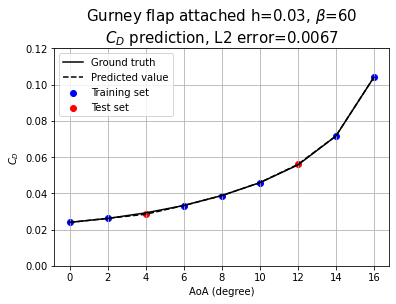

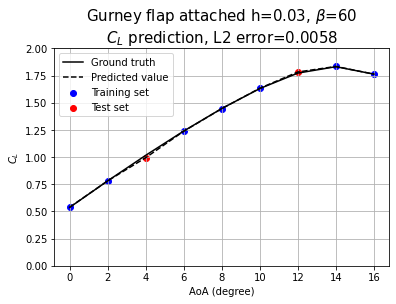

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0022, L2 error of Cl: 0.0053


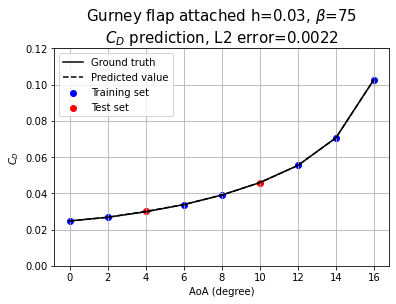

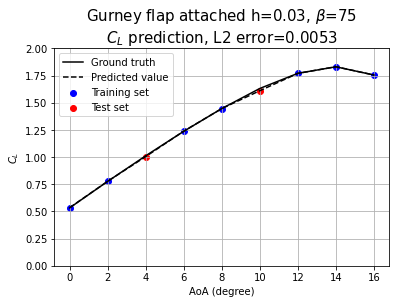

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0021, L2 error of Cl: 0.0027


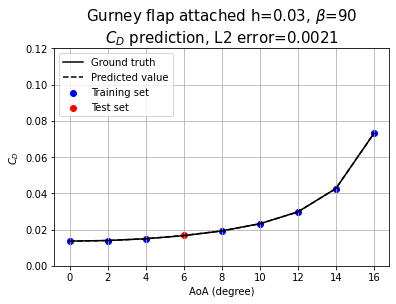

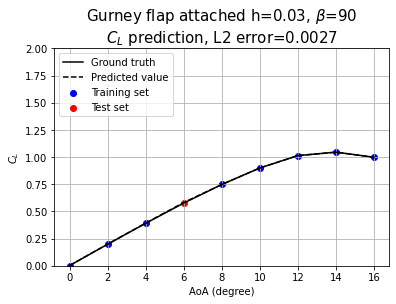

In [103]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]


for i in range(0, 16):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue[:,0] - y_corres[:,0])**2) / np.sum(y_corres[:,0]**2))
    l2_error_Cl = np.sqrt(np.sum((predictedValue[:,1] - y_corres[:,1])**2) / np.sum(y_corres[:,1]**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    else:
        print('L2 error of Cd: {0:0.4f}, L2 error of Cl: {1:0.4f}'.format(l2_error_Cd, l2_error_Cl))
    
    cl = predicted[n_alpha*i:n_alpha*(i+1),1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig)
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig)
    CD = y[n_alpha*i:n_alpha*(i+1),0]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]*np.max(alpha)
    aTest = np.array(alpha_test)[:,0]*np.max(alpha)
    
    CLCD_trainTestSplit_Plot(i, CD, cd, CL, cl, aTrain, aTest, iTrain, iTest)